# Agentic Architecture 1 : Reflection

The reflection achitecture involves an agent critiquing and revisiting its own output before returning a final answer.

The **Reflection** architecture involves an agent critiquing and revising its own output before returning a final answer. Instead of a single-pass generation, it engages in a multi-step internal monologue: produce, evaluate, and improve. This mimics the human process of drafting, reviewing, and editing to catch errors and enhance quality.

In [1]:
import os
import json
from typing import List, TypedDict, Optional
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
import logging

# for pretty priting
from rich.console import Console
from rich.markdown import Markdown
from rich.syntax import Syntax

from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic AI Architecture - Reflection"

if not os.environ.get("LANGCHAIN_API_KEY"):
    print("LANGCHAIN_API_KEY not found. Please create a .env file and set it for tracing.")


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

logging.info("Environment variable loaded and tracing is set up.")


2025-12-29 15:33:30,755 - root - INFO - Environment variable loaded and tracing is set up.


In [2]:
# Defining data schema for 3 part system : Generator, Critic and Refiner

class Draftcode(BaseModel):
    code: str = Field(description="The Python code generated to solve the user's request.")
    explanation: str = Field(description="A brief explanation of how the code works.")

class Critique(BaseModel):
    has_error: bool = Field(description="Does the code have some potential bugs or logical errors?")
    is_efficient: bool = Field(description="Is the code written in an efficient and optimal way?")
    suggested_improvements: List[str] = Field(description="Specific, actionble suggestions for improving the code.")
    critique_summary: str = Field(description="A summary of the critique.")

class FinalRefinedCode(BaseModel):
    refined_code: str = Field(description="The final improved python code.")
    refinement_summary: str = Field(description="A summary of the changes made based on the critique")

logging.info("Pydantic models for Drfting code, a critique and FinalRefinedCode have been defined")

2025-12-29 15:33:30,767 - root - INFO - Pydantic models for Drfting code, a critique and FinalRefinedCode have been defined


In [3]:
# initializing the ollama llm as the LLM engine
from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen2.5-coder:3b", temperature=0.2)
console = Console()

print("Ollama LLM and Console are initialized.")

#Testing ollama model in working
"""
messages = [
    (
        "system",
        "You are a helpful assistant that generates useful coding snippets.",
    ),
    ("human", "Generate a python code for explaining recursion method in programming."),
]
ai_msg = llm.invoke(messages)
ai_msg
"""

Ollama LLM and Console are initialized.


'\nmessages = [\n    (\n        "system",\n        "You are a helpful assistant that generates useful coding snippets.",\n    ),\n    ("human", "Generate a python code for explaining recursion method in programming."),\n]\nai_msg = llm.invoke(messages)\nai_msg\n'

In [4]:
# Creating the Generator Node
def generator_node(state):
    """Generate the initial draft of the code."""
    console.print("Generating Initial Draft...")
    generator_llm = llm.with_structured_output(Draftcode)
    
    prompt = f"""You are an expert Python Programmer. Write a Python function the following request. Provide a simple, clear implementation and an explanation.
    Provide a simple, clear implementation and an explanation.

    Request: {state["user_request"]}
    """
    draft = generator_llm.invoke(prompt)
    return {"draft": draft.model_dump()}

In [5]:
# Creating the Critic Node
def critic_node(state):
    "Critique the generated code for errors and inefficiencies."
    console.print("Finding problem with the drafting...")
    critique_llm = llm.with_structured_output(Critique)

    code_to_critique = state['draft']['code']

    prompt = f"""You are an expert code reviewer and senior Python developer. Your task is to perform a thorough critique of the following code.
    
    Analyze the code for:
    1.  **Bugs and Errors:** Are there any potential runtime errors, logical flaws, or edge cases that are not handled?
    2.  **Efficiency and Best Practices:** Is this the most efficient way to solve the problem? Does it follow standard Python conventions (PEP 8)?
    3.  **Another more efficient way to solve the problem:** If there is any other efficient, improved or refined way to solve it, mention it.
    
    Provide a structured critique with specific, actionable suggestions.
    
    Code to Review:
    ```python
    {code_to_critique}
    ```
    """

    critique = critique_llm.invoke(prompt)
    return {"critique": critique.model_dump()}

In [6]:
# Creating the refiner node
def refiner_node(state):
    """Refines the code based on the critique."""
    console.print("Refining Code...")
    refiner_llm = llm.with_structured_output(FinalRefinedCode)

    draft_code = state['draft']['code']
    critique_suggestions = json.dumps(state['critique'], indent=2)

    prompt = f""" 
    You are an expert Python Programmer tasked with refining a piece of code based on a critique.
    Your goal is to rewrite the original code, implementing all the suggested improvements from the critique.
    ** Original Code **
    ```python
    {draft_code}
    ```            
    **Critique and Suggestion:**
    {critique_suggestions}

    Please provide the final, refined code in python syntax and a summary of the changes you made.
    """

    refined_code = refiner_llm.invoke(prompt)
    return {"refined_code": refined_code.model_dump()}


In [7]:
# Orchestating the reflection Workflow with LangGraph

In [8]:
# Defining the Graph State
class ReflectionState(TypedDict):
    user_request: str
    draft: Optional[dict]
    critique: Optional[dict]
    refined_code: Optional[dict]

logging.info("ReflectionState TypeDict defined.")

2025-12-29 15:33:31,154 - root - INFO - ReflectionState TypeDict defined.


In [9]:
graph_builder = StateGraph(ReflectionState)

# add the nodes to the graph
graph_builder.add_node("generator", generator_node)
graph_builder.add_node("critic", critic_node)
graph_builder.add_node("refiner", refiner_node)

In [10]:
# Define the workflow edges
graph_builder.set_entry_point("generator")
graph_builder.add_edge("generator","critic")
graph_builder.add_edge("critic", "refiner")
graph_builder.add_edge("refiner", END)

# Compiling the graph
reflection_app = graph_builder.compile()

logging.info("Reflection graph has been compiled successfully!")

2025-12-29 15:33:31,180 - root - INFO - Reflection graph has been compiled successfully!


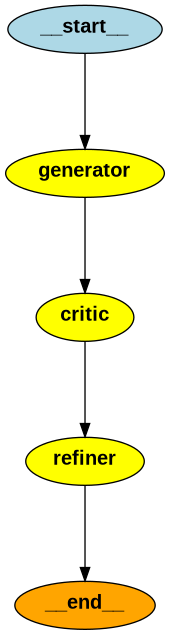

In [11]:
# Let's Visualize the graph
try:
    from IPython.display import Image, display
    png_image = reflection_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"Graph Visualization failed: {e}. Please ensure pygraphviz is installed.")

In [12]:
# End-to-End Execution and Evaluation

In [13]:
## Running the Full reflection Workflow
user_request = "Write a Python function to solve a recursion problem."
initial_input = {"user_request": user_request}

console.print(f"Kicking off Reflection workflow for request:'{user_request}'\n ")

final_state = None
for state_update in reflection_app.stream(initial_input, stream_mode="values"):
    final_state = state_update

console.print("\n Reflection workflow Complete!")

Kicking off Reflection workflow for request:'Write a Python function to solve a recursion problem.'

Generating Initial Draft...

2025-12-29 15:33:39,514 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Finding problem with the drafting...

2025-12-29 15:34:03,840 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Refining Code...

2025-12-29 15:34:20,114 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Reflection workflow Complete!

In [14]:
# Check if final_state is available and has the expected keys
if final_state and 'draft' in final_state and 'critique' in final_state and 'refined_code' in final_state:
    console.print(Markdown("### Initial Draft..."))
    console.print(Markdown(f"**Explanation:** {final_state['draft']['explanation']}"))
    console.print(Syntax(final_state['draft']['code'], "python", theme="monokai", line_numbers=True))

    console.print(Markdown("\n### Critique..."))
    console.print(Markdown(f"**Summary:** {final_state['critique']['critique_summary']}"))
    if final_state['critique']['suggested_improvements']:
        console.print(Markdown(f"**Improvements Suggested:**"))
        for improvement in final_state['critique']['suggested_improvements']:
            console.print(Markdown(f"- {improvement}"))
    else:
        console.print(Markdown(f"**Improvements Suggested:**"))
        console.print(Markdown(f"The provided code is efficient and follows standard Python conventions. No further code adjustment required."))

    console.print(Markdown("\n--- ### Final Refined Code ---"))
    console.print(Markdown(f"**Refinement Summary:** {final_state['refined_code']['refinement_summary']}"))
    console.print(Syntax(final_state['refined_code']['refined_code'], "python", theme="monokai", line_numbers=True))
else:
    console.print("[bold red]Error: The `final_state` is not available or is incomplete. Please check the execution of the previous cells.[/bold red]")

Initial Draft...

Explanation: This function calculates the factorial of a given number n using recursion. The factorial of a        
non-negative integer n is the product of all positive integers less than or equal to n. For example, the factorial 
of 5 (denoted as 5!) is 5 * 4 * 3 * 2 * 1 = 120.                                                                   

The function starts with a base case: if n is 0 or 1, it returns 1 because the factorial of both 0 and 1 is defined
to be 1. For any other value of n, the function calls itself with the argument n-1 and multiplies the result by n. 
This recursive call continues until it reaches the base case.

  1 def factorial(n):                                                                                              
  2     # Base case: if n is 0 or 1, return 1                                                                      
  3     if n == 0 or n == 1:                                                                                       
  4         return 1                                                                                               
  5     else:                                                                                                      
  6         # Recursive case: n * factorial of (n-1)                                                               
  7         return n * factorial(n-1)                                                                              

Critique...

Summary: The provided code is a correct implementation of the factorial function using recursion. It handles the   
base case and correctly calls itself with n-1 in the recursive case. The code follows standard Python conventions  
(PEP 8) as it uses proper indentation, spacing, and naming conventions. However, for larger values of n, the       
recursive approach can lead to a stack overflow due to deep recursion. Consider using memoization or an iterative  
approach to improve efficiency.

Improvements Suggested:

 • Consider using memoization to optimize the recursive function for larger values of n.

--- ### Final Refined Code ---

Refinement Summary: The refined code introduces memoization to store previously computed results in a dictionary   
called memo. This prevents redundant calculations and significantly improves the efficiency of the function for    
larger values of n by avoiding stack overflow issues associated with deep recursion.

   1 ```python                                                                                                     
   2 def factorial(n, memo={}):                                                                                    
   3     # Base case: if n is 0 or 1, return 1                                                                     
   4     if n == 0 or n == 1:                                                                                      
   5         return 1                                                                                              
   6     elif n in memo:                                                                                           
   7         return memo[n]                                                                                        
   8     else:                                                                                                     
   9         # Recursive case: n * factorial of (n-1)                                                              
  10         result = n * factorial(n-1, memo)                                                                     
  11         memo[n] = result                                                                                      
  12         return result                                                                                         
  13 ```                                                                                                           

In [15]:
# Quantitative Evaluation(LLM-as-a-Judge)
class CodeEvaluation(BaseModel):
    correctness_score: int = Field(description="Score from 1-10 on whether the code is logically correct.")
    efficiency_score: int = Field(description="Score from 1-10 on the code's algorithmic efficiency.")
    style_score: int = Field(description="Score from 1-10 on code style and readability (PEP 8). ")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(CodeEvaluation)

def evaluate_code(code_to_evaluate: str):
    prompt = f"""You are an expert judge of Python code. Evaluate the following function on a scale of 1-10 for correctness, efficiency, and style. Provide a brief justification.
    
    Code:
    ```python
    {code_to_evaluate}
    ```
    """
    return judge_llm.invoke(prompt)

if final_state and 'draft' in final_state and 'refined_code' in final_state:
    console.print("Evaluating Initial Draft...")
    initial_draft_evaluation = evaluate_code(final_state['draft']['code'])
    console.print(initial_draft_evaluation.model_dump())

    console.print("\nEvaluating Refined Code...")
    refined_code_evaluation = evaluate_code(final_state['refined_code']['refined_code'])
    console.print(refined_code_evaluation.model_dump())
else:
    console.print("[bold red]Error: Cannot perform evaluation because the `final_state` is incomplete.[/bold red]")


Evaluating Initial Draft...

2025-12-29 15:34:37,869 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


{
    'correctness_score': 10,
    'efficiency_score': 8,
    'style_score': 9,
    'justification': "The function `factorial` is correctly implemented using recursion to calculate the factorial 
of a given number. The base case handles the cases where `n` is 0 or 1, returning 1 as the factorial of both 0 and 
1 is defined as 1. The recursive case multiplies `n` by the factorial of `n-1`, which correctly computes the 
factorial for any non-negative integer input. However, the efficiency score could be slightly lower due to Python's
recursion limit, which can cause a stack overflow for large values of `n`. Additionally, the style score is high as
the function follows standard Python naming conventions and includes comments explaining its purpose and logic."
}

Evaluating Refined Code...

2025-12-29 15:34:55,464 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


{
    'correctness_score': 9,
    'efficiency_score': 8,
    'style_score': 7,
    'justification': "The function `factorial` is correctly implemented to calculate the factorial of a number 
using recursion. It handles base cases for `n = 0` and `n = 1`, and uses memoization to store previously computed 
results to optimize performance. The code is efficient in terms of time complexity, as it avoids redundant 
calculations by storing intermediate results. However, the style score could be improved by adding a docstring to 
describe the function's purpose and parameters. Additionally, using a more descriptive variable name like `result` 
instead of `n` would enhance readability."
}